In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ryani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


read data from csv file and print to see if read correctly

In [2]:
df = pd.read_csv('StackOverflow-Dataset.csv', delimiter=";")
print(df.head(10))

                                               title   label
0              Using entries from other kivy classes  python
1   Package python software with pylucene dependency  python
2           Extracting time with regex from a string  python
3  How do I add specific headers before each form...  python
4  Barplot from a dataframe using a column to set...  python
5  python how to collect a specific file from a l...  python
6  &lt;select&gt; element is displayed with defau...  python
7  Multiple GET Requests, merge json response int...  python
8  Python SpeechRecognition mic in list_microphon...  python
9                speech recognition not taking input  python


Print out number of words in dataset

In [3]:
wordsPreClean = df['title'].apply(lambda x: len(x.split(' '))).sum()
print(wordsPreClean)

135140


<AxesSubplot:>

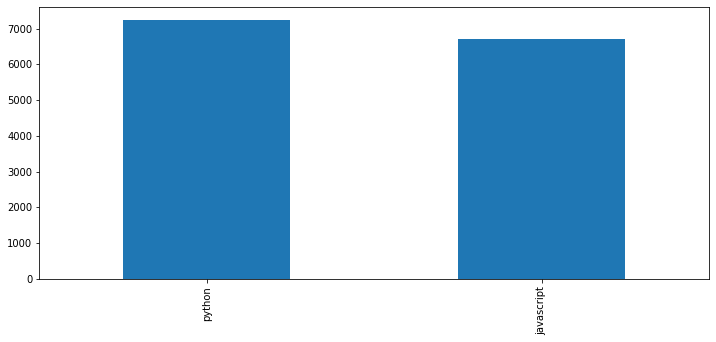

In [4]:
plt.figure(figsize=(12,5))
df.label.value_counts().plot(kind='bar')

The data is fairly even

In [5]:
def print_plot(index):
    example = df[df.index == index][['title', 'label']].values[0]
    if len(example) > 0:
        print(example[0])
        print('label:', example[1])
print_plot(51)

Creating a histogram raises: &quot;only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices&quot;
label: python


Clean the text for easier and better processing

In [6]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;_.]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_.]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub(' ', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub('\w*\d\w*','',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text
    return text

In [7]:
df['title'] = df['title'].apply(clean_text)
print_plot(51)

creating histogram raises quot integers slices ellipsis numpy newaxis none integer boolean arrays valid indices quot
label: python


In [8]:
wordsPostCLean = df['title'].apply(lambda x: len(x.split(' '))).sum()
print(wordsPostCLean)

91688


In [9]:
print('the processiung has reduced the number of words by:')
print(wordsPreClean-wordsPostCLean)

the processiung has reduced the number of words by:
43452


In [10]:
 for row in df.index:
     if(df['label'][row] == 'python'):
         df['label'][row] = [1,0]
     else:
         df['label'][row] = [0,1]


Split data into train,validation,test

In [11]:
df = df.sample(frac=1).reset_index(drop=True) #shuffles data
train_data = df.iloc[:round(len(df.index)*0.6),:] #takes 60% for test data
x_train = train_data.title
y_train = list(train_data.label)


validation_data = df.iloc[round(len(df.index)*0.6):round(len(df.index)*0.8),:] #takes 20% for validation
x_val = validation_data.title
y_val = list(validation_data.label)

test_data = df.iloc[round(len(df.index)*0.8):round(len(df.index)),:] #takes 20% for test
x_test = test_data.title
y_test = list(test_data.label)

Creates a document-term matrix using a count vector

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer() # instantiate count vector
vectorizer = CountVectorizer()
vectorizer.fit(x_train)
vectorizer.vocabulary_
train_vector  = vectorizer.transform(x_train)
train_x = list(train_vector.toarray())
training = np.array(train_x)
output = np.array(y_train)

In [13]:
class NeuralNetwork():
    def __init__(self,x,y,neurons,alpha,epochs,dropout,dropout_percent):
        self.x = x
        self.y = y
        self.neurons = neurons
        self.alpha = alpha
        self.epochs = epochs
        self.dropout = dropout
        self.dropout_percent = dropout_percent
        # randomly initialize our weights with mean 0
        np.random.seed(1)
        self.synapse_0 = 2*np.random.random((len(self.x[0]), self.neurons)) - 1
        self.synapse_1 = 2*np.random.random((self.neurons, 2)) - 1

    def sigmoid(self,x):
        output = 1/(1+np.exp(-x))
        return output

    def dsigmoid(self,x): #derivative of sigmoid function
        return x*(1-x)

    def train(self):
        print ("Training with %s neurons, alpha:%s, dropout:%s %s" % (self.neurons, str(self.alpha), self.dropout, self.dropout_percent if self.dropout else '') )
        print ("Input matrix: %sx%s    Output matrix: %sx%s" % (len(self.x),len(self.x[0]),1,2))
        

        last_mean_error = 1
       #sets up variables to keep track of previous weights
        prev_synapse_0_weight_update = np.zeros_like(self.synapse_0)
        prev_synapse_1_weight_update = np.zeros_like(self.synapse_1)

        synapse_0_direction_count = np.zeros_like(self.synapse_0)
        synapse_1_direction_count = np.zeros_like(self.synapse_1)
            
        for j in iter(range(self.epochs+1)):

            # Feed forward through layers 0, 1, and 2
            layer_0 = self.x
            layer_1 = self.sigmoid(np.dot(layer_0, self.synapse_0))
                 
            if(self.dropout):
                layer_1 *= np.random.binomial([np.ones((len(self.x),self.neurons))],1-self.dropout_percent)[0] * (1.0/(1-self.dropout_percent))

            layer_2 = self.sigmoid(np.dot(layer_1, self.synapse_1))

            # finds error
            layer_2_error = self.y - layer_2

                    
            #back-prop using chain rule
            layer_2_delta = layer_2_error * self.dsigmoid(layer_2)

            #according to thge weights how much did layer 1 contribute to layer 2's errors
            layer_1_error = layer_2_delta.dot(self.synapse_1.T)

            #back-prop using chain rule
            layer_1_delta = layer_1_error * self.dsigmoid(layer_1)
            
            synapse_1_weight_update = (layer_1.T.dot(layer_2_delta))
            synapse_0_weight_update = (layer_0.T.dot(layer_1_delta))
            
            if(j > 0):
                synapse_0_direction_count += np.abs(((synapse_0_weight_update > 0)+0) - ((prev_synapse_0_weight_update > 0) + 0))
                synapse_1_direction_count += np.abs(((synapse_1_weight_update > 0)+0) - ((prev_synapse_1_weight_update > 0) + 0))        
            #update the weights
            self.synapse_1 += self.alpha * synapse_1_weight_update
            self.synapse_0 += self.alpha * synapse_0_weight_update
            #keeps track of previous weights
            prev_synapse_0_weight_update = synapse_0_weight_update
            prev_synapse_1_weight_update = synapse_1_weight_update

    

    def pred(self,data):
        # input layer is our data
        l0 = data
        # matrix multiplication of input and hidden layer
        l1 = self.sigmoid(np.dot(l0, self.synapse_0))
        # output layer
        l2 = self.sigmoid(np.dot(l1, self.synapse_1))
        return l2


    def classify(self,data):
        return_results = []
        for i in range(len(data)):
            results = self.pred(data[i])
            if(results[0] > results[1]):
                return_results.append(1)
            else:
                return_results.append(0)
            
        return return_results


In [14]:
NN = NeuralNetwork(training,output,20,0.01,1000,False,0.5)
start_time = time.time()
NN.train()
elapsed_time = time.time() - start_time
if(elapsed_time> 120):
    print("processing time:", round(elapsed_time/60), "minutes")
else:
    print ("processing time:", elapsed_time, "seconds")

Training with 20 neurons, alpha:0.01, dropout:False 
Input matrix: 8363x7110    Output matrix: 1x2
processing time: 15 minutes


In [15]:
finalLabels = NN.classify(training)
total = len(finalLabels)
count = 0
actualLabels = []
for i in range(len(output)):
    if(output[i][0] ==1):
        actualLabels.append(1)
    else:
        actualLabels.append(0)

for i in range(len(finalLabels)):
    if actualLabels[i] == finalLabels[i]:
        count +=1

print("Confusion Matrix:")
print()
y_actual = pd.Series(actualLabels, name='Actual')
y_pred = pd.Series(finalLabels, name='Predicted')
df_confusion = pd.crosstab(y_actual,y_pred)
print(df_confusion)

print("-------------------------")
print("Training Data Accuracy:")
NNTrainAccuracy = float(count/total)
print(NNTrainAccuracy)

Confusion Matrix:

Predicted     0     1
Actual               
0          3995    41
1            57  4270
-------------------------
Training Data Accuracy:
0.9882817170871697


In [16]:
val_vector = vectorizer.transform(x_val)
val_x = list(val_vector.toarray())
validation = np.array(val_x)
val_output = np.array(y_val)

In [17]:
val_finalLabels = NN.classify(validation)

val_total = len(val_finalLabels)
val_count = 0

val_actualLabels = []
for i in range(len(val_output)):
    if(val_output[i][0] ==1):
        val_actualLabels.append(1)
    else:
        val_actualLabels.append(0)

for i in range(len(val_finalLabels)):
    if val_actualLabels[i] == val_finalLabels[i]:
        val_count +=1

print("Confusion Matrix:")
print()
val_y_actual = pd.Series(val_actualLabels, name='Actual')
val_y_pred = pd.Series(val_finalLabels, name='Predicted')
df_confusion = pd.crosstab(val_y_actual,val_y_pred)
print(df_confusion)

print("-------------------------")
print("Validation Data Accuracy:")
NNvalAccuracy = float(val_count/val_total)
print(NNvalAccuracy)

Confusion Matrix:

Predicted     0     1
Actual               
0          1181   167
1           167  1272
-------------------------
Validation Data Accuracy:
0.8801578758521708


In [18]:
test_vector = vectorizer.transform(x_test)
test_x = list(test_vector.toarray())
testing = np.array(test_x)
test_output = np.array(y_test)

In [19]:
test_finalLabels = NN.classify(testing)

test_total = len(test_finalLabels)
test_count = 0

test_actualLabels = []
for i in range(len(test_output)):
    if(test_output[i][0] ==1):
        test_actualLabels.append(1)
    else:
        test_actualLabels.append(0)

for i in range(len(test_finalLabels)):
    if test_actualLabels[i] == test_finalLabels[i]:
        test_count +=1

print("Confusion Matrix:")
print()
test_y_actual = pd.Series(test_actualLabels, name='Actual')
test_y_pred = pd.Series(test_finalLabels, name='Predicted')
df_confusion = pd.crosstab(test_y_actual,test_y_pred)
print(df_confusion)

print("-------------------------")
print("Test Data Accuracy:")
NNtestAccuracy = float(test_count/test_total)
print(NNtestAccuracy)

Confusion Matrix:

Predicted     0     1
Actual               
0          1158   158
1           203  1269
-------------------------
Test Data Accuracy:
0.8705164992826399
